In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
sys.path.insert(0, "../../")

In [8]:
import bosonic_jax.jax_qutip as jqt
from jax import jit, grad
from jax.experimental.ode import odeint
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import qutip as qt


from jax import device_put

# Apply the default theme
sns.set_theme()

from jax.config import config
config.update("jax_enable_x64", True)

from scipy.integrate import odeint as odeint_sp

# QuTiP

In [9]:
def pi_exp_qt(omega_d):
    results = qt.mesolve([5.0/2.0*qt.sigmaz(), [qt.sigmax(), 'cos(omega_d*t)']], qt.ket2dm(qt.basis(2,0)), np.linspace(0,np.pi,101), args={"omega_d": omega_d})
    return np.real((results.states[-1] * qt.sigmaz()).tr())

In [10]:
pi_exp_qt(4.95), pi_exp_qt(5.0)

(-0.9997216696066519, -0.9948769257038724)

# SciPy

In [32]:
omega_q = 5.0 #GHz
Omega = .01
H0 = omega_q/2.0*np.array(jqt.sigmaz())
H1 = Omega*np.array(jqt.sigmax())
g_state = np.array(jqt.ket2dm(jqt.basis(2,0)))
g_state_flat = np.concatenate([g_state.reshape(4,), np.zeros_like(g_state).reshape(4,)])
print(g_state_flat)

c_ops = np.array([])


def flat(rho):
    return np.concatenate([np.real(rho).reshape(4,),np.imag(rho).reshape(4,)])

def unflat(rho):
    return rho[:4].reshape(2,2) + 1.0j*(rho[4:].reshape(2,2))

def pi_exp_sp(omega_d):    
    t_list = np.linspace(0,np.pi/Omega,101)
    def H_func(rho_flat, t, H0_val, H1_val, c_ops_val):
        rho = unflat(rho_flat)
        fac = np.cos((omega_d+0j)*t)
        H = H0 + H1*fac
        rho_dot = -1.0j * (H @ rho) 
        rho_dot += -1.0j * (-rho @ H)
        return flat(rho_dot)
    
    states = odeint_sp(H_func, g_state_flat, t_list, (H0, H1, c_ops))
    final_state = states[-1]
    return np.real(np.trace(unflat(final_state) @ np.array(jqt.sigmaz())))

[1. 0. 0. 0. 0. 0. 0. 0.]


In [33]:
pi_exp_sp(4.95), pi_exp_sp(5.0)

(0.9241884713043749, -1.0000142699123102)

# JAX

In [9]:
omega_q = device_put(5.0) #GHz
Omega = device_put(.1)
H0 = omega_q/2.0*jqt.sigmaz()
H1 = Omega*jqt.sigmax()
g_state = jqt.ket2dm(jqt.basis(2,0)) + 0.0j

c_ops = jnp.array([])

@jit
def pi_exp(omega_d):    
    t_list = jnp.linspace(0,jnp.pi/Omega,101)
    def H_func(rho, t, H0_val, H1_val, c_ops_val):
        fac = jnp.cos((omega_d+0j)*t)
        H = H0 + H1*fac
        rho_dot = -1.0j * (H @ rho)
        rho_dot += -1.0j * (-rho @ H)
        return rho_dot
    
    states = odeint(H_func, g_state, t_list, H0, H1, c_ops)
    final_state = states[-1]
    return jnp.real(jnp.trace(final_state @ jqt.sigmaz()))

In [10]:
pi_exp(4.95), pi_exp(5.0)

(DeviceArray(-0.53735125, dtype=float64),
 DeviceArray(-0.99994763, dtype=float64))

# Optimization w JAX

In [11]:
from jax.example_libraries.optimizers import adam
from jax import jit, value_and_grad

step_size = 2e-3
epochs = 1800
opt_init, opt_update, get_params = adam(step_size)

@jit
def cost(x):
    return pi_exp(x)

@jit
def update(x, opt_state):
    value, grads = value_and_grad(cost)(x)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

def run_training(opt_state, num_print = epochs//10):
        x = get_params(opt_state)
        log = {"cost":[], "time":[]}
        log["cost"].append(cost(x))

        for epoch in range(epochs):
            start_time = time.time()
            x, opt_state, loss_val = update(x, opt_state)
            log["cost"].append(loss_val)
            log["time"].append(time.time() - start_time)
            if epoch % num_print == 0:
                print("=" * 20)
                print("Epoch: ", epoch)
                print("Time: ", log["time"][-1])
                print("Cost: ", log["cost"][-1])
                print("omega_d: ", get_params(opt_state))
        return log, opt_state

In [15]:
opt_state = opt_init(4.9)
log, opt_state = run_training(opt_state)
omega_d_opt = get_params(opt_state)

Epoch:  0
Time:  0.025523900985717773
Cost:  0.36276322175876535
omega_d:  4.9019999999988055
Epoch:  180
Time:  0.014974832534790039
Cost:  -0.9999975947634898
omega_d:  4.999507698858035
Epoch:  360
Time:  0.016843080520629883
Cost:  -0.9999976063086777
omega_d:  4.999500386805909
Epoch:  540
Time:  0.014711141586303711
Cost:  -0.9999976063086781
omega_d:  4.999500386745226
Epoch:  720
Time:  0.015829086303710938
Cost:  -0.9999976063086781
omega_d:  4.9995003867452255
Epoch:  900
Time:  0.01471710205078125
Cost:  -0.9999976063086786
omega_d:  4.999500386745222
Epoch:  1080
Time:  0.016277074813842773
Cost:  -0.9999976063086777
omega_d:  4.999500386745218
Epoch:  1260
Time:  0.01784801483154297
Cost:  -0.9999976063086771
omega_d:  4.999500386745218
Epoch:  1440
Time:  0.015022039413452148
Cost:  -0.9999976063086777
omega_d:  4.999500386745219
Epoch:  1620
Time:  0.016129016876220703
Cost:  -0.9999976063086771
omega_d:  4.999500386745218


In [16]:
def plot_cost_vs_epoch(log):
    _, ax = plt.subplots(1, 1)
    ax.plot(log["cost"])
    ax.set_xlabel(r"${\rm epoch\ number}$")
    ax.set_ylabel(r"${\rm \langle \sigma_z \rangle}$")
    ax.set_title(r"${\rm training\ history}$")
    return ax

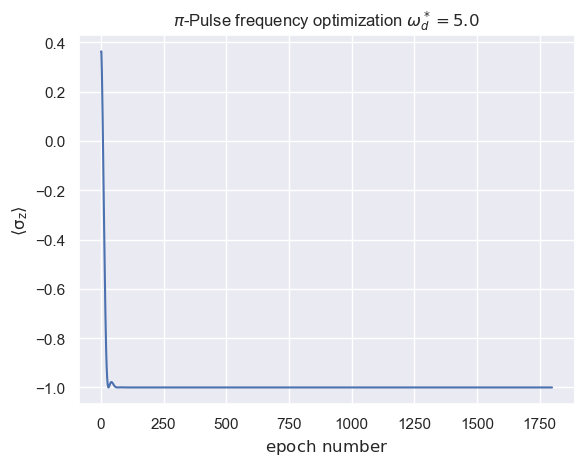

In [17]:
ax = plot_cost_vs_epoch(log)
ax.set_title(f"$\pi$-Pulse frequency optimization $\\omega_d^* = {omega_d_opt:.3}$")
plt.show()